In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from PIL import Image
import copy
import gc
import time
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score



# GPU Hafıza Temizliği
try:
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

# Cihaz Seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Çalışma Cihazı: {device}")
if torch.cuda.is_available():
    print(f"GPU Modeli: {torch.cuda.get_device_name(0)}")

Çalışma Cihazı: cuda
GPU Modeli: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# --- AYARLAR ---
# BURAYI KENDİ YOLUNUZLA GÜNCELLEYİN
DATA_DIR = r"C:\Users\ramis\Desktop\Weather"

# Geliştirilmiş Hiperparametreler
NUM_EPOCHS = 20           # Daha iyi öğrenmesi için artırıldı
BATCH_SIZE = 8            # 4GB VRAM için güvenli değer
LEARNING_RATE = 0.0001    # Daha hassas öğrenme için düşürüldü
WEIGHT_DECAY = 1e-4       # Overfitting engellemek için ceza katsayısı

print("Best Choices!!")

Best Choices!!


In [3]:
# --- VERİ SETİ VE AUGMENTATION ---

# Eğitim için: Daha zorlayıcı veri artırma (Renk ve Döndürme eklendi)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test/Val için: Sadece standartlaştırma
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        # train ve val klasörlerini hariç tutarak sınıfları al
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and d not in ['train', 'val']])
        
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    path = os.path.join(root, file)
                    parent = os.path.basename(os.path.dirname(path))
                    if parent in self.classes:
                        self.image_paths.append(path)
                        self.labels.append(self.classes.index(parent))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert("RGB")
            label = self.labels[idx]
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Hata: {self.image_paths[idx]} okunamadı.")
            return torch.zeros(3, 224, 224), 0

# Veriyi Hazırla
full_dataset = WeatherDataset(DATA_DIR) # Ham veri
print(f"Toplam Görsel: {len(full_dataset)}")
print(f"Sınıflar: {full_dataset.classes}")

# Stratified Split (Dengeli Bölme)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(full_dataset.image_paths, full_dataset.labels))

# Train ve Val setlerine farklı transformlar uygula
train_set = Subset(WeatherDataset(DATA_DIR, transform=train_transforms), train_idx)
val_set = Subset(WeatherDataset(DATA_DIR, transform=val_transforms), val_idx)

# DataLoader'lar
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Eğitim Seti: {len(train_set)} | Doğrulama Seti: {len(val_set)}")

Toplam Görsel: 356
Sınıflar: ['cloudy', 'rainy', 'sunny', 'sunrise']
Eğitim Seti: 284 | Doğrulama Seti: 72


In [4]:
# --- EĞİTİM FONKSİYONU ---
def train_model_smart(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    print(f"{'-'*10} Eğitim Başlıyor {'-'*10}")
    
    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_set)
        
        # --- VALIDATION ---
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)
        
        val_loss = val_running_loss / len(val_set)
        val_acc = 100 * correct.double() / total
        
        # Learning Rate Güncellemesi
        scheduler.step()
        
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # En iyi modeli kaydet
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"    --> Kaydedildi! (Yeni En İyi: {best_acc:.2f}%)")

    # En iyi ağırlıkları yükle ve döndür
    model.load_state_dict(best_model_wts)
    return model, history

# Model Oluşturucu Yardımcı Fonksiyon
def get_model(name, num_classes):
    if name == 'EfficientNet-B0':
        m = models.efficientnet_b0(weights='DEFAULT')
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    elif name == 'EfficientNet-B4':
        m = models.efficientnet_b4(weights='DEFAULT')
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    return m.to(device)

print("Training Function, Train, Validation, LR")

Training Function, Train, Validation, LR


In [5]:
# --- MODELLERİ EĞİT ---
models_list = ['EfficientNet-B0', 'EfficientNet-B4']
results = {}

for m_name in models_list:
    # Hafıza temizliği
    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"\n{'='*20} {m_name} EĞİTİLİYOR {'='*20}")
    
    # 1. Modeli Yükle
    model = get_model(m_name, len(full_dataset.classes))
    
    # 2. Optimizer ve Loss (AdamW + Scheduler)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Her 7 epochta bir öğrenme hızını %10una düşür
    step_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # 3. Eğitimi Başlat
    best_model, history = train_model_smart(model, criterion, optimizer, step_scheduler, NUM_EPOCHS)
    
    # 4. Sonuçları Tahmin Et ve Sakla
    best_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    results[m_name] = {
        'model': best_model,
        'y_true': all_labels,
        'y_pred': all_preds,
        'history': history
    }
    print(f"{m_name} tamamlandı.")


==================== EfficientNet-B0 EĞİTİLİYOR ====================
---------- Eğitim Başlıyor ----------
Epoch 1/20 | Train Loss: 1.2971 | Val Loss: 1.1415 | Val Acc: 65.28%
    --> Kaydedildi! (Yeni En İyi: 65.28%)
Epoch 2/20 | Train Loss: 1.0716 | Val Loss: 0.9083 | Val Acc: 76.39%
    --> Kaydedildi! (Yeni En İyi: 76.39%)
Epoch 3/20 | Train Loss: 0.8366 | Val Loss: 0.7354 | Val Acc: 77.78%
    --> Kaydedildi! (Yeni En İyi: 77.78%)
Epoch 4/20 | Train Loss: 0.6492 | Val Loss: 0.6408 | Val Acc: 77.78%
Epoch 5/20 | Train Loss: 0.5577 | Val Loss: 0.5675 | Val Acc: 81.94%
    --> Kaydedildi! (Yeni En İyi: 81.94%)
Epoch 6/20 | Train Loss: 0.4575 | Val Loss: 0.5591 | Val Acc: 80.56%
Epoch 7/20 | Train Loss: 0.4081 | Val Loss: 0.4768 | Val Acc: 83.33%
    --> Kaydedildi! (Yeni En İyi: 83.33%)
Epoch 8/20 | Train Loss: 0.3670 | Val Loss: 0.4903 | Val Acc: 84.72%
    --> Kaydedildi! (Yeni En İyi: 84.72%)
Epoch 9/20 | Train Loss: 0.3755 | Val Loss: 0.4765 | Val Acc: 83.33%
Epoch 10/20 | Train

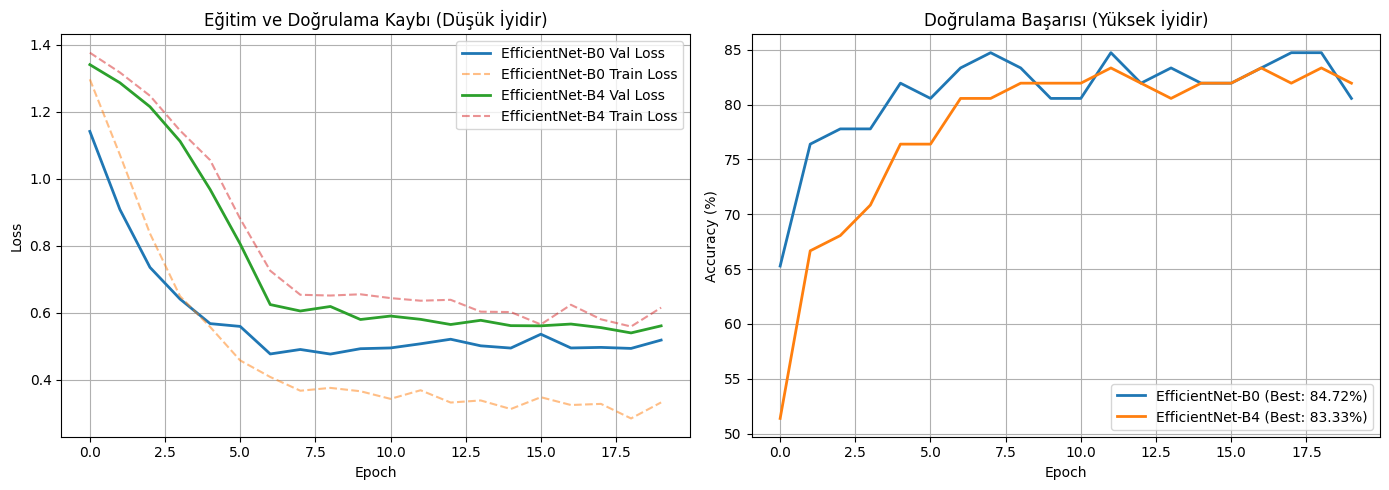

In [6]:
# --- GRAFİKLER ---
plt.figure(figsize=(14, 5))

# Loss (Kayıp) Grafiği
plt.subplot(1, 2, 1)
for m_name in models_list:
    hist = results[m_name]['history']
    plt.plot(hist['val_loss'], label=f"{m_name} Val Loss", linewidth=2)
    plt.plot(hist['train_loss'], linestyle='--', alpha=0.5, label=f"{m_name} Train Loss")
plt.title("Eğitim ve Doğrulama Kaybı (Düşük İyidir)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy (Başarı) Grafiği
plt.subplot(1, 2, 2)
for m_name in models_list:
    acc_hist = results[m_name]['history']['val_acc']
    best_val = max(acc_hist)
    plt.plot(acc_hist, label=f"{m_name} (Best: {best_val:.2f}%)", linewidth=2)
plt.title("Doğrulama Başarısı (Yüksek İyidir)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# --- SAF HIZ TESTİ (INFERENCE SPEED) ---
print("\n=== GERÇEK GPU HIZ TESTİ (Pure Inference) ===")

def measure_pure_inference(model, input_size=(1, 3, 224, 224), iterations=100):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    
    # GPU Isıtma (Warm-up - İlk işlem yavaştır)
    for _ in range(10):
        _ = model(dummy_input)
        
    torch.cuda.synchronize() # GPU'nun hazır olmasını bekle
    start = time.time()
    
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(dummy_input)
            
    torch.cuda.synchronize() # İşlemlerin bitmesini bekle
    end = time.time()
    
    fps = iterations / (end - start)
    return fps

speed_results = {}
for m_name in models_list:
    fps = measure_pure_inference(results[m_name]['model'])
    speed_results[m_name] = fps
    print(f"🚀 {m_name}: {fps:.2f} FPS (Görüntü/Saniye)")


=== GERÇEK GPU HIZ TESTİ (Pure Inference) ===
🚀 EfficientNet-B0: 112.26 FPS (Görüntü/Saniye)
🚀 EfficientNet-B4: 60.24 FPS (Görüntü/Saniye)


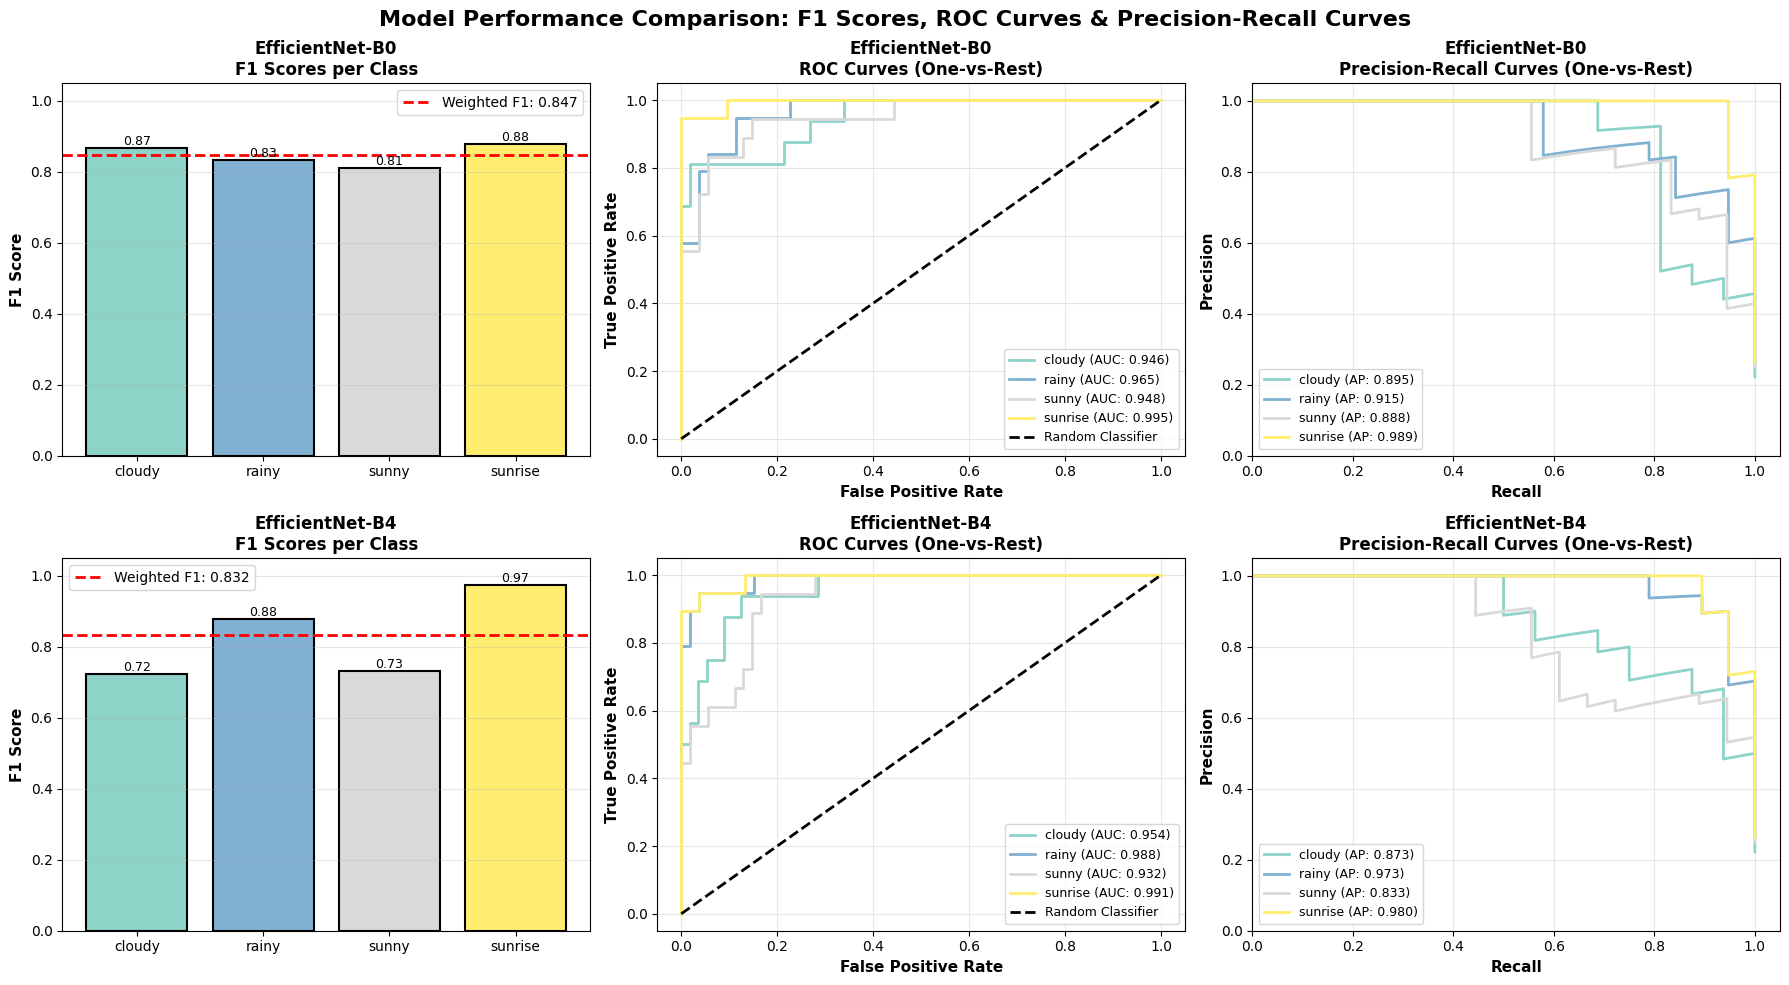


✅ All metrics visualized successfully!
📊 Top Row: EfficientNet-B0 | Bottom Row: EfficientNet-B4


In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for multi-class ROC and PR curves
num_classes = len(full_dataset.classes)

# Create figure with 2 rows (models) x 3 columns (metrics)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison: F1 Scores, ROC Curves & Precision-Recall Curves', fontsize=16, fontweight='bold')

# Color palette for classes
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

# --- ITERATE THROUGH BOTH MODELS ---
for row, m_name in enumerate(models_list):
    y_true = np.array(results[m_name]['y_true'])
    y_pred = np.array(results[m_name]['y_pred'])
    
    # Get model for probability predictions
    model = results[m_name]['model']
    model.eval()
    
    all_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
    
    y_proba = np.array(all_probs)
    
    # --- COLUMN 1: F1 SCORE BAR CHART ---
    ax_f1 = axes[row, 0]
    f1_per_class = []
    for i in range(num_classes):
        f1 = f1_score(y_true == i, y_pred == i, average='binary', zero_division=0)
        f1_per_class.append(f1)
    
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    
    bars = ax_f1.bar(full_dataset.classes, f1_per_class, color=colors, edgecolor='black', linewidth=1.5)
    ax_f1.axhline(y=weighted_f1, color='red', linestyle='--', linewidth=2, label=f'Weighted F1: {weighted_f1:.3f}')
    ax_f1.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax_f1.set_title(f'{m_name}\nF1 Scores per Class', fontsize=12, fontweight='bold')
    ax_f1.set_ylim([0, 1.05])
    ax_f1.legend()
    ax_f1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax_f1.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # --- COLUMN 2: ROC CURVE (One-vs-Rest) ---
    ax_roc = axes[row, 1]
    y_bin = label_binarize(y_true, classes=range(num_classes))
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'{full_dataset.classes[i]} (AUC: {roc_auc:.3f})', 
                    linewidth=2, color=colors[i])
    
    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    ax_roc.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax_roc.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax_roc.set_title(f'{m_name}\nROC Curves (One-vs-Rest)', fontsize=12, fontweight='bold')
    ax_roc.legend(loc='lower right', fontsize=9)
    ax_roc.grid(alpha=0.3)
    
    # --- COLUMN 3: PRECISION-RECALL CURVE ---
    ax_pr = axes[row, 2]
    
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
        avg_precision = np.trapezoid(precision[::-1], recall[::-1])
        ax_pr.plot(recall, precision, label=f'{full_dataset.classes[i]} (AP: {avg_precision:.3f})', 
                   linewidth=2, color=colors[i])
    
    ax_pr.set_xlabel('Recall', fontsize=11, fontweight='bold')
    ax_pr.set_ylabel('Precision', fontsize=11, fontweight='bold')
    ax_pr.set_title(f'{m_name}\nPrecision-Recall Curves (One-vs-Rest)', fontsize=12, fontweight='bold')
    ax_pr.set_xlim([0, 1.05])
    ax_pr.set_ylim([0, 1.05])
    ax_pr.legend(loc='best', fontsize=9)
    ax_pr.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ All metrics visualized successfully!")
print("📊 Top Row: EfficientNet-B0 | Bottom Row: EfficientNet-B4")


=== SONUÇ TABLOSU ===
             Model Best Val Acc (%) F1-Score (%) Speed (FPS)
0  EfficientNet-B0            84.72        84.69       112.3
1  EfficientNet-B4            83.33        83.23        60.2


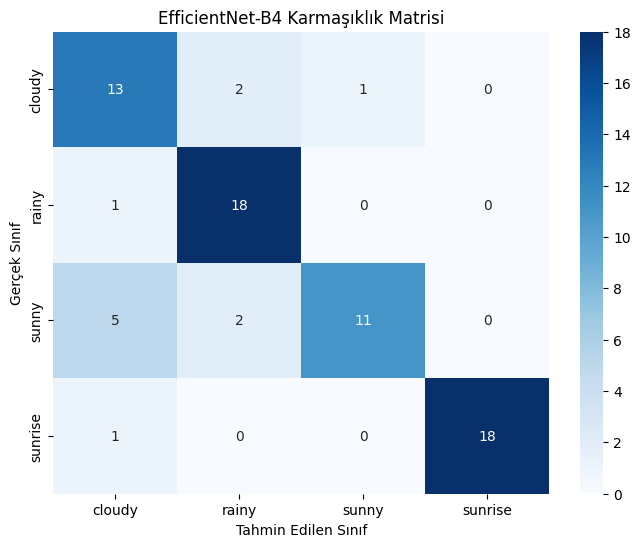

In [8]:
# --- RAPORLAMA ---
final_data = []

for m_name in models_list:
    y_t = results[m_name]['y_true']
    y_p = results[m_name]['y_pred']
    
    acc = accuracy_score(y_t, y_p) * 100
    f1 = f1_score(y_t, y_p, average='weighted') * 100
    fps = speed_results[m_name]
    
    final_data.append({
        "Model": m_name,
        "Best Val Acc (%)": f"{acc:.2f}",
        "F1-Score (%)": f"{f1:.2f}",
        "Speed (FPS)": f"{fps:.1f}"
    })

print("\n=== SONUÇ TABLOSU ===")
df_res = pd.DataFrame(final_data)
print(df_res)

# En iyi modelin (Genelde B4) Confusion Matrix'i
best_model_name = 'EfficientNet-B4'
cm = confusion_matrix(results[best_model_name]['y_true'], results[best_model_name]['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.classes, 
            yticklabels=full_dataset.classes)
plt.title(f"{best_model_name} Karmaşıklık Matrisi")
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

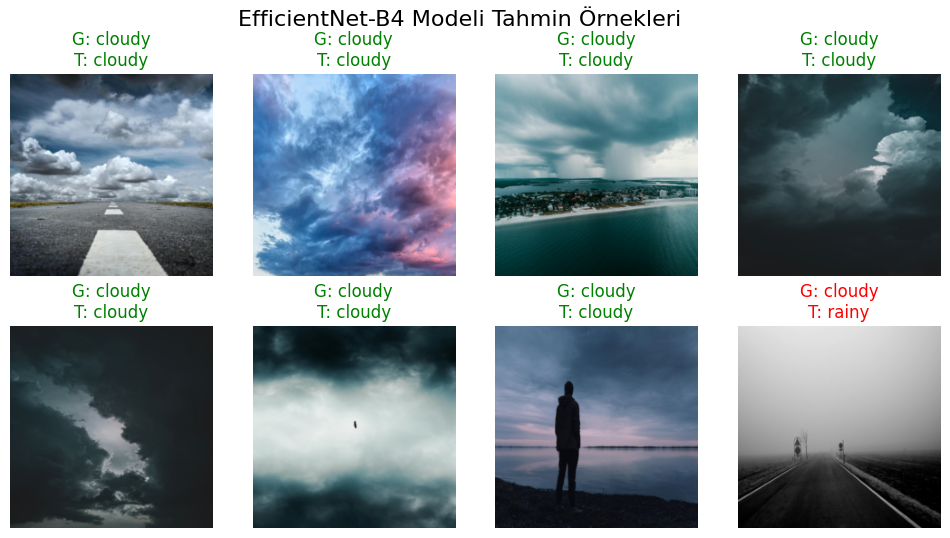

In [9]:
# GÖRSEL TAHMİN ÖRNEKLERİ
def visualize_predictions(model, loader, classes, model_name):
    model.eval()
    # Batch Size küçük olduğu için 8 görsel çıkmayabilir, kontrol ediyoruz
    images, labels = next(iter(loader))
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    num_images = min(8, len(images)) # En az 8 veya batch kadar
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{model_name} Modeli Tahmin Örnekleri", fontsize=16)
    
    for i in range(num_images):
        ax = plt.subplot(2, 4, i+1)
        img = images[i].cpu()
        img = inv_normalize(img)
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        true_label = classes[labels[i]]
        pred_label = classes[preds[i].item()]
        
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"G: {true_label}\nT: {pred_label}", color=color)
        plt.axis('off')
    plt.show()

# Son eğitilen model (B4) üzerinden örnek göster
visualize_predictions(model, val_loader, full_dataset.classes, "EfficientNet-B4")

In [10]:
import time

def measure_inference_speed(model, loader, model_name):
    model.eval()
    # GPU'yu ısıt (ilk işlem genelde yavaştır, saymayalım)
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    _ = model(dummy_input)
    
    start_time = time.time()
    total_images = 0
    
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            _ = model(images)
            total_images += images.size(0)
            # Testi kısa tutmak için 100 görselden sonra duralım
            if total_images >= 100:
                break
                
    end_time = time.time()
    total_time = end_time - start_time
    fps = total_images / total_time  # Saniyedeki Kare Sayısı (FPS)
    
    print(f"⚡ {model_name} Hız Testi:")
    print(f"   - Toplam Süre: {total_time:.4f} saniye")
    print(f"   - İşlenen Görsel: {total_images}")
    print(f"   - Hız (FPS): {fps:.2f} img/sec (Saniyede kaç resim?)")
    print("-" * 30)

# Testi Çalıştır
print("\n=== HIZ PERFORMANSI KARŞILAŞTIRMASI ===")

# EfficientNet-B0 Testi
model_b0 = get_model('EfficientNet-B0', len(full_dataset.classes))
measure_inference_speed(model_b0, val_loader, "EfficientNet-B0")

# EfficientNet-B4 Testi
model_b4 = get_model('EfficientNet-B4', len(full_dataset.classes))
measure_inference_speed(model_b4, val_loader, "EfficientNet-B4")


=== HIZ PERFORMANSI KARŞILAŞTIRMASI ===
⚡ EfficientNet-B0 Hız Testi:
   - Toplam Süre: 2.8204 saniye
   - İşlenen Görsel: 72
   - Hız (FPS): 25.53 img/sec (Saniyede kaç resim?)
------------------------------
⚡ EfficientNet-B4 Hız Testi:
   - Toplam Süre: 2.9591 saniye
   - İşlenen Görsel: 72
   - Hız (FPS): 24.33 img/sec (Saniyede kaç resim?)
------------------------------
